In [1]:
import io
import pathlib
import requests
import time
import zipfile

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics
import tqdm

from dataset_fetcher import download_uci_bikeshare
from real_games import multi_shapley_values, result_plots, substitution_payout_function_generator, shapley_values, plot_phi

In [2]:
sns.set_style('whitegrid')
plt.rcParams['savefig.dpi'] = 300
figures_dir = pathlib.Path('figures')
figures_dir.mkdir(exist_ok=True)
with (figures_dir / '.gitignore').open('w') as gitignore:
    gitignore.write('*.png\n')

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import the dataset

In [4]:
data_dir = pathlib.Path('bikeshare_dataset')
train_df, test_df = download_uci_bikeshare(data_dir)

# Get feature importances via fitting a boosted trees model

We drop `atemp` since it is highly correlated to `temp`.

We drop `instant` because our tree-based model will not be able to extrapolate on features that have different ranges in train and test.

In [5]:
# justify dropping atemp by correlation
np.corrcoef(test_df['temp'], test_df['atemp'])[1, 0]

0.9827918638710511

All features performance:
train fit (r2): 0.959 | test fit (r2): 0.641


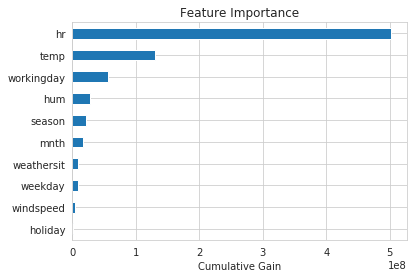

Selected features: ['hr', 'temp', 'workingday', 'hum', 'season']
Selected features performance:
train fit (r2): 0.934 | test fit (r2): 0.632


In [6]:
features = [
    # the tree-based model will not be able to
    # capture the linear trend in the instant variable
    # across our train-test split
#     'instant', 
    'season', 
    'mnth', 
    'hr', 
    'holiday', 
    'weekday', 
    'workingday', 
    'weathersit', 
    'temp', 
    # dropped due to high correlation to 'temp'
#     'atemp', 
    'hum', 
    'windspeed'
]

target = 'cnt'

# fit and score the model
model = lgb.LGBMRegressor()
x_train = train_df[features]
x_test = test_df[features]
y_train = train_df[target]
y_test = test_df[target]
model.fit(x_train, y_train)
print(f'All features performance:'
      f'\ntrain fit (r2): {sklearn.metrics.r2_score(y_train, model.predict(x_train)):.3f}'
      f' | test fit (r2): {sklearn.metrics.r2_score(y_test, model.predict(x_test)):.3f}')

importances = pd.Series(
    model.booster_.feature_importance('gain'), 
    index=features
)
importances.sort_values().plot('barh')
plt.xlabel('Cumulative Gain')
plt.title('Feature Importance')
plt.show()

features = importances.sort_values(ascending=False).index.tolist()[:5]
print('Selected features:', features)

# fit and score the top-features model
x_train = x_train.loc[:, features].copy()
x_test = x_test.loc[:, features].copy()
model.fit(x_train, y_train)
y_hat_train = model.predict(x_train)
y_hat_test = model.predict(x_test)
print(f'Selected features performance:'
      f'\ntrain fit (r2): {sklearn.metrics.r2_score(y_train, y_hat_train):.3f}'
      f' | test fit (r2): {sklearn.metrics.r2_score(y_test, y_hat_test):.3f}')

# Explaining the model

## For context, plot the distributions of the model's inputs and outputs

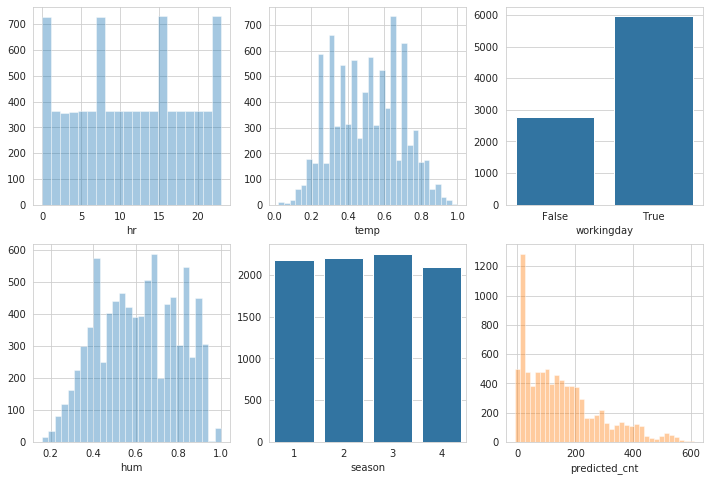

In [7]:
n_col = 3
n_row = int(np.ceil((x_test.shape[1] + 1) / n_col))
subplot_size = 4
f, axes = plt.subplots(n_row, n_col, figsize=(subplot_size * n_col, subplot_size * n_row),)
for i, column_name in enumerate(x_test):
    ax = axes[i//n_col, i%n_col]
    if x_test[column_name].dtype.name in ('bool', 'category'):
        sns.countplot(x=column_name, data=x_test, color=sns.color_palette()[0], ax=ax)
        ax.set_ylabel('')
    else:
        sns.distplot(x_test[column_name], kde=False, ax=ax)
else:
    i += 1
    ax = axes[i//n_col, i%n_col]
    y_hat_test = pd.Series(model.predict(x_test), index=x_test.index, name='predicted_cnt')
    sns.distplot(y_hat_test, kde=False, ax=ax, color=sns.color_palette()[1])
    
f.savefig(figures_dir / 'bikeshare_distributions.png', bbox_inches='tight')
f.show()

## Let's explain a rondom row from the dataset

In [8]:
# examine rows with low predictions vs rows with middling predictions
random_sample = pd.concat([x_test, y_hat_test, test_df['instant']], axis=1).set_index('instant').sample(10, random_state=0)
chosen_point = random_sample.iloc[3:4]
chosen_counter = random_sample.iloc[2:3]
def color_rows(x):
    if x.name == chosen_point.index:
        arg = 'background: lightsalmon'
    elif x.name == chosen_counter.index:
        arg = 'background: lightblue'
    else:
        arg = ''
    return [arg for _ in x]
display(random_sample
        .style
        .set_caption('Randomly Sampled Points')
        .apply(color_rows, axis=1))

,hr,temp,workingday,hum,season,predicted_cnt
instant,,,,,,
14646,10,0.72,True,0.74,3,136.209
14654,18,0.76,True,0.62,3,513.231
11362,14,0.36,True,0.62,2,113.087
11729,21,0.64,True,0.65,2,209.874
12756,16,0.9,True,0.35,2,241.268
9187,16,0.24,True,0.93,1,62.101
10507,21,0.52,False,0.72,1,100.18
16879,1,0.42,True,0.71,4,15.2955
15539,15,0.66,False,0.39,4,445.044


In [9]:
# display the full row for the selected point
test_df[test_df['instant'] == chosen_point.index[0]]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
3083,11729,2012-05-08,2,1,5,21,False,2,True,2,0.64,0.6061,0.65,0.2836,21,202,223


## Single-reference explanation
To answer the question "Why did this point receive a score of over 200 while another similar point received a score of 113?" we compare it against that point in a single-reference game.

In [10]:
model_fn = model.predict
model_input = x_test[test_df['instant'] == chosen_point.index[0]]
counterfactual_input = x_test.loc[test_df['instant'] == chosen_counter.index[0]]
payout_fn = next(substitution_payout_function_generator(
    model_fn, model_input, counterfactual_input))
sv = shapley_values(
    n_players=x_test.shape[1], payout=payout_fn)
print(f'Prediction: {model_fn(model_input)[0]:.2f}')
print(f'Counterfactual prediction: {model_fn(counterfactual_input)[0]:.2f}')
print(f'Delta {payout_fn(set(range(model_input.shape[1]))):.2f} attributed as:')
pd.DataFrame([sv], columns=model_input.columns).style.format('{:.2f}')

100%|██████████| 1/1 [00:00<00:00, 1217.50it/s]

Prediction: 209.87
Counterfactual prediction: 113.09
Delta 96.79 attributed as:


,hr,temp,workingday,hum,season
0,6.65,94.24,0.00,-4.10,0.00


## Playing n games (one per input)

pre-computing payout functions...


100%|██████████| 8734/8734 [00:00<00:00, 10905.60it/s]


computing shapley values...


100%|██████████| 8734/8734 [00:07<00:00, 1221.78it/s]


,hr,temp,workingday,hum,season
0,2.5142,46.8499,1.31746,6.69104,1.92296


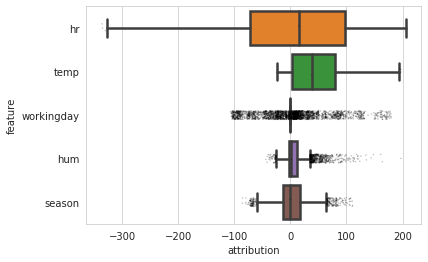

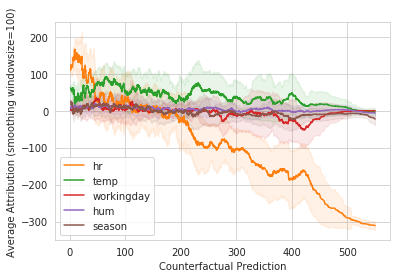

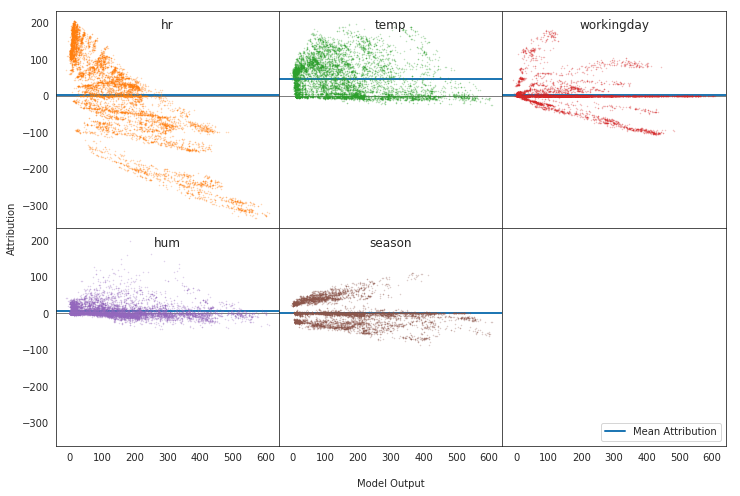

In [11]:
phi_0, phi = multi_shapley_values(model_fn, model_input, x_test)
phi_0_marginal, phi_marginal = phi_0, phi  # save these attributions to compare against the joint-marginal

display(phi.mean().to_frame().T.style.set_caption('Mean Attributions'))

result_plots(phi_0, phi, fig_path=figures_dir, figname='bikeshare_marginal')

## Shortcoming: the mean hides information

In [12]:
# attribution to hr is <3, while to temp >45, but in single-reference
# games, the magnitude of attributions to hr tend to be highest
phi_marginal.abs()['hr'].gt(phi_marginal.abs()['temp']).mean()

0.6733455461415159

In [13]:
# hr has highest attribution 60% of the time, temp less than 30%
phi_marginal.abs().eq(phi_marginal.abs().max(axis=1), axis=0).mean()

hr            0.600069
temp          0.289100
workingday    0.068812
hum           0.023243
season        0.020151
dtype: float64

## Comparing against other summer workdays
We consider the following prompt:

"This example takes place during a summer workingday. How significant is it that this is a summer workingday rather than a summer vacation day?" 

To answer this question, we compare against other `season`=2 & `hr`=21 points where `workingday` is False.

In [14]:
summer_vacation_mask = ~x_test['workingday'] & x_test['hr'].eq(21) & x_test['season'].eq('2')
print(f'Comparing against the {summer_vacation_mask.sum()} points which are 9pm on summer vacation days')

Comparing against the 28 points which are 9pm on summer vacation days


In [15]:
summer_mask = x_test['hr'].eq(21) & x_test['season'].eq('2')
print(f'On second thought, instead comparing against the {summer_mask.sum()} points which are 9pm on summer days, setting `workingday` to be false')

On second thought, instead comparing against the 92 points which are 9pm on summer days, setting `workingday` to be false


In [16]:
artificial_counterfactuals = x_test[summer_mask].copy()
artificial_counterfactuals['workingday'] = False
phi_0, phi = multi_shapley_values(model_fn, model_input, artificial_counterfactuals)

pre-computing payout functions...


100%|██████████| 92/92 [00:00<00:00, 45915.75it/s]


computing shapley values...


100%|██████████| 92/92 [00:00<00:00, 1088.82it/s]


,hr,temp,workingday,hum,season
mean,0,30.0338,14.3932,5.81708,0
std,0,37.4478,2.61467,12.0479,0


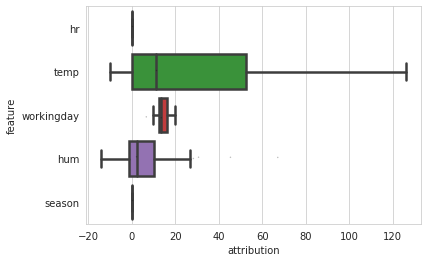

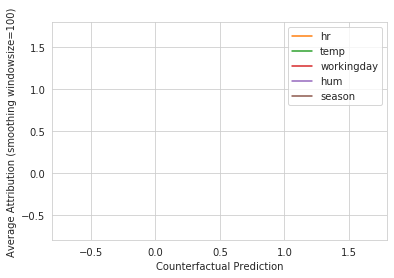

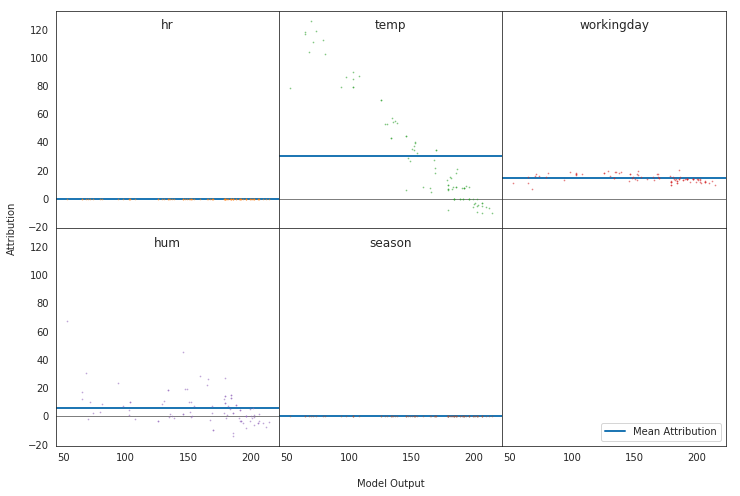

In [17]:
display(phi.agg(['mean', 'std']).style.set_caption('Mean Attributions'))
result_plots(phi_0, phi, fig_path=figures_dir, figname='bikeshare_summer_vacation')

In [18]:
model_fn(model_input)[0] - phi_0.mean()

phi_0    50.244119
dtype: float64

## Comparing to points scored closer to 223 (the ground truth label)
NOTE: Cut from the paper for brevity

To answer the question "What kept the model from assigning this point a score closer to the true label of 223?" we compare it against points in the score range 215-230.

In [19]:
better_pred_mask = y_hat_test.between(215, 230, inclusive=True)
print(f'Comparing against the {better_pred_mask.mean():.1%} of points which had predicted `cnt` between 215 and 230 (inclusive)')

Comparing against the 2.9% of points which had predicted `cnt` between 215 and 230 (inclusive)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,hr,temp,workingday,hum,season
mean,0,-5.65344,12.4221,-3.46696,0
std,0,3.2712,1.0032,3.44298,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


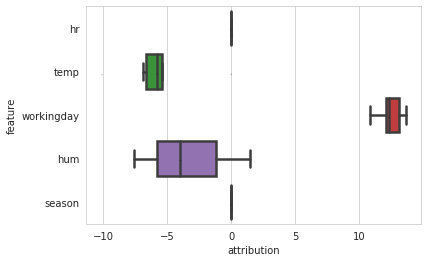

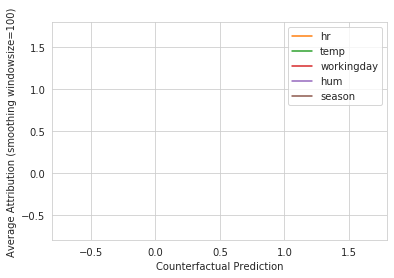

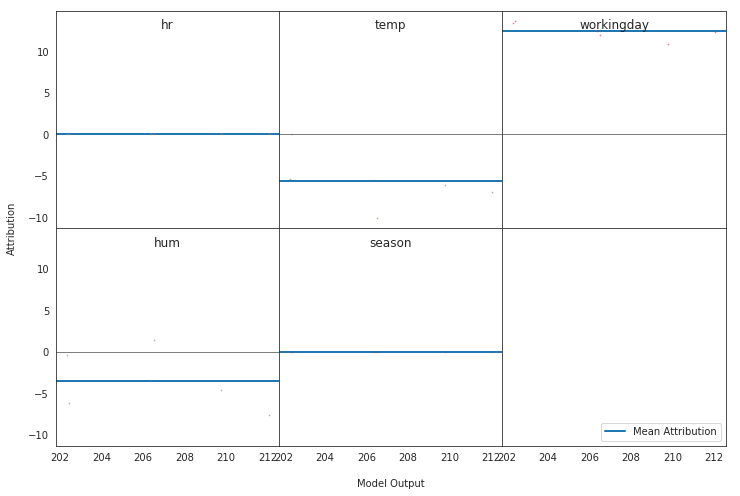

In [20]:
display(phi[better_pred_mask].agg(['mean', 'std']).style.set_caption('Mean Attributions'))
result_plots(phi_0[better_pred_mask], phi[better_pred_mask], fig_path=figures_dir, figname='bikeshare_215-230')

# Compare against only higher scoring predictions

## Score above our model
If we want to understand what kept our model from scoring higher, we can compare to points with higher predictions.

There are 2329 rows with prediction 209.9+ (26.7% of the data)


,hr,temp,workingday,hum,season,predicted_cnt
6514,20,0.60,True,0.53,4,265.898707
7507,18,0.44,False,0.54,4,241.660555
3847,17,0.84,False,0.24,2,367.177891
2626,20,0.56,True,0.49,2,226.267630
5167,17,0.84,True,0.53,3,514.802206


pre-computing payout functions...


100%|██████████| 2329/2329 [00:00<00:00, 13156.72it/s]


computing shapley values...


100%|██████████| 2329/2329 [00:01<00:00, 1341.80it/s]


,hr,temp,workingday,hum,season
0,-136.326,34.1514,-10.8804,2.04482,-9.1612


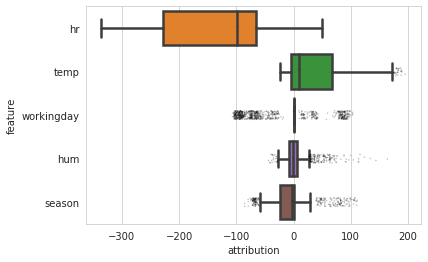

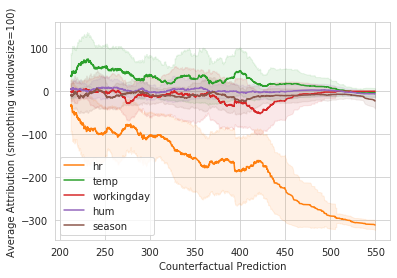

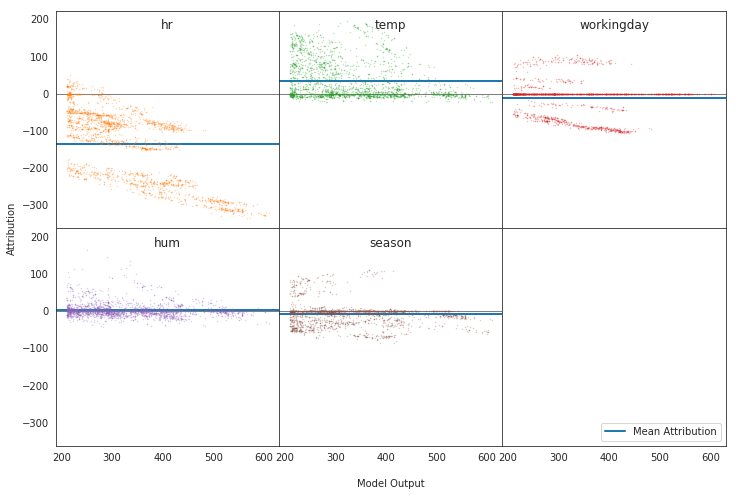

In [21]:
pred = model_fn(model_input)[0]
idx = y_hat_test[y_hat_test.gt(pred)].index
high_pred_inputs = x_test.loc[idx]
high_pred_rows = pd.concat([high_pred_inputs, y_hat_test.loc[idx]], axis=1)
print(f'There are {high_pred_rows.shape[0]} rows with prediction {pred:.1f}+ '
      f'({high_pred_rows.shape[0]/x_test.shape[0]:.1%} of the data)')
display(high_pred_rows.sample(5, random_state=0))

phi_0, phi = multi_shapley_values(model_fn, model_input, high_pred_inputs)
display(phi.mean().to_frame().T.style.set_caption('Mean Attributions'))

result_plots(phi_0, phi, fig_path=figures_dir, figname='bikeshare_high_pred')
# result_plots(phi_0, phi.div(phi.abs().sum(axis=1), axis='rows'), 'above Median')

## Score below our model
If we want to understand what kept our model from scoring lower, we can compare to points with lower predictions.

There are 6402 rows with prediction below 209.9 (73.3% of the data)


,hr,temp,workingday,hum,season,predicted_cnt
6514,20,0.60,True,0.53,4,265.898707
7507,18,0.44,False,0.54,4,241.660555
3847,17,0.84,False,0.24,2,367.177891
2626,20,0.56,True,0.49,2,226.267630
5167,17,0.84,True,0.53,3,514.802206


pre-computing payout functions...


100%|██████████| 6402/6402 [00:00<00:00, 14281.56it/s]


computing shapley values...


100%|██████████| 6402/6402 [00:05<00:00, 1254.78it/s]


,hr,temp,workingday,hum,season
0,53.0245,51.4914,5.75557,8.38443,5.95619


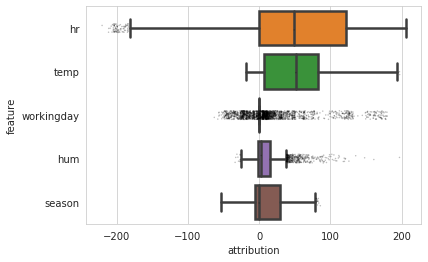

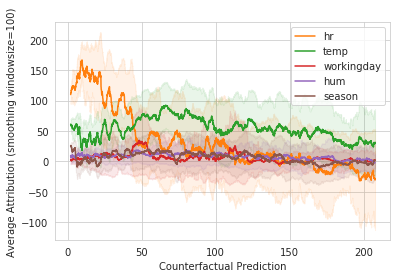

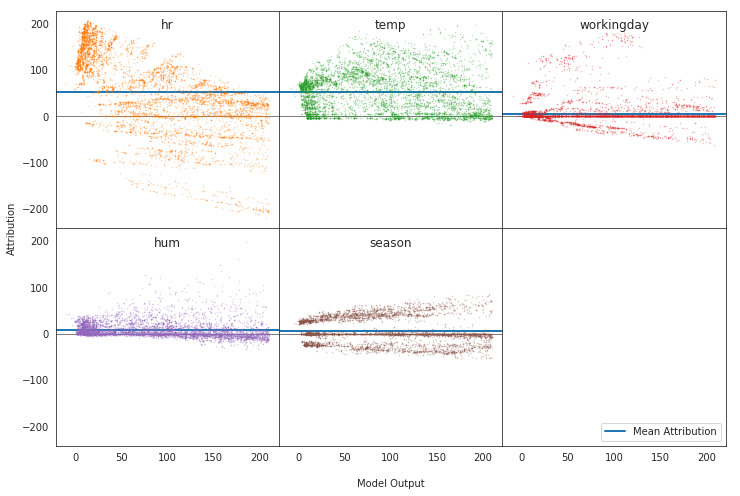

In [22]:
idx = y_hat_test[y_hat_test < pred].index
low_pred_inputs = x_test.loc[idx]
low_pred_rows = pd.concat([low_pred_inputs, y_hat_test.loc[idx]], axis=1)
print(f'There are {low_pred_rows.shape[0]} rows with prediction below {pred:.1f} '
      f'({low_pred_rows.shape[0]/x_test.shape[0]:.1%} of the data)')
display(high_pred_rows.sample(5, random_state=0))

phi_0, phi = multi_shapley_values(model_fn, model_input, low_pred_inputs)
display(phi.mean().to_frame().T.style.set_caption('Mean Attributions'))

result_plots(phi_0, phi, fig_path=figures_dir, figname='bikeshare_low_pred')


# Compare against uniform distribution

pre-computing payout functions...


100%|██████████| 8734/8734 [00:00<00:00, 12544.37it/s]


computing shapley values...


100%|██████████| 8734/8734 [00:07<00:00, 1112.91it/s]


,hr,temp,workingday,hum,season
0,3.36616,60.4305,2.96461,12.1206,2.51008


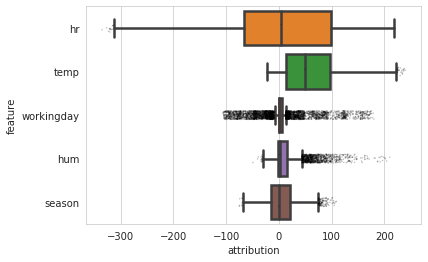

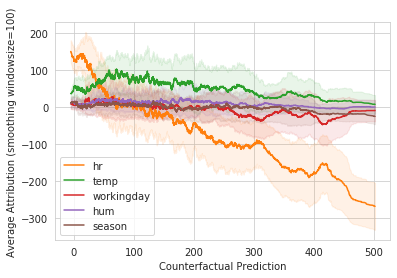

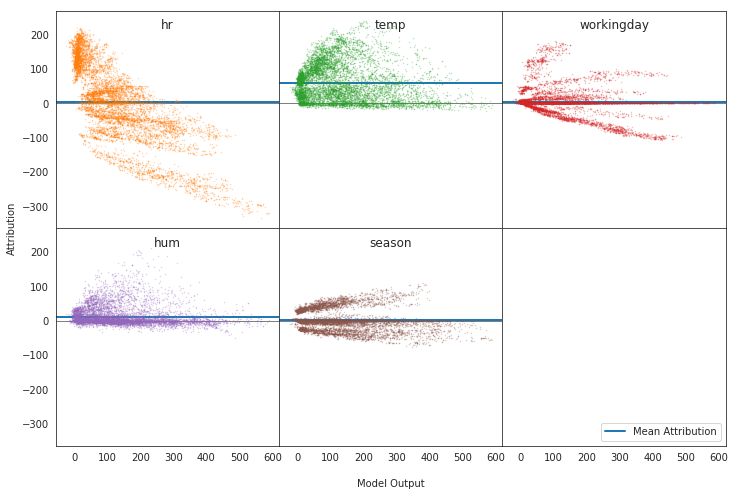

In [23]:
# sample randomly in each column from possible ranges
sample_dict = dict()
rng = np.random.RandomState(0)
for column_name, column in x_test.iteritems():
    if column.dtype.name in ('bool', 'category'):
        sample_dict[column_name] = rng.choice(column.unique(), x_test.shape[0])
    else:
        sample_dict[column_name] = rng.choice(np.linspace(*column.agg(['min','max']), num=10_000), x_test.shape[0])

# build a dataframe with matching datatypes
uniform_sample_df = pd.DataFrame(sample_dict)
for column_name in x_test:
    uniform_sample_df[column_name] = uniform_sample_df[column_name].astype(x_test[column_name].dtype)

phi_0, phi = multi_shapley_values(model_fn, model_input, uniform_sample_df)
phi_0_unif, phi_unif = phi_0, phi # save these
display(phi.mean().to_frame().T.style.set_caption('Mean Attributions'))

result_plots(phi_0, phi, fig_path=figures_dir, figname='bikeshare_uniform')

# Joint marginal
If the dataset has high correlations, we might consider building a joint-marginal distribution. Let's look at the correlation matrix.

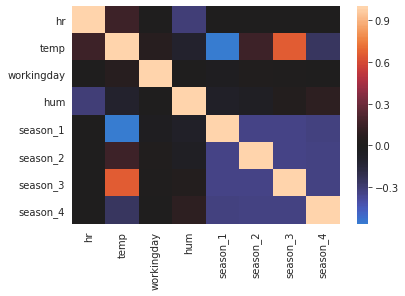

In [24]:
sns.heatmap(pd.get_dummies(x_test).corr(), center=0)

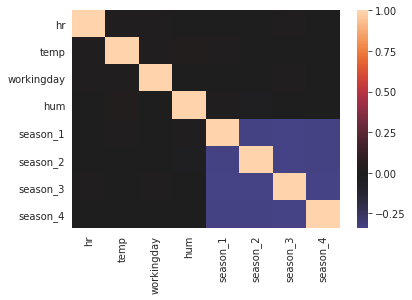

In [25]:
# sample randomly in each column separately
sample_dict = dict()
rng = np.random.RandomState(0)
for column_name, column in x_test.iteritems():
    sample_dict[column_name] = rng.choice(column.values, x_test.shape[0])

# build a dataframe with matching datatypes
jm_sample_df = pd.DataFrame(sample_dict)
for column_name in x_test:
    jm_sample_df[column_name] = jm_sample_df[column_name].astype(x_test[column_name].dtype)
    
# show how correlation has been mitigated
sns.heatmap(pd.get_dummies(uniform_sample_df).corr(), center=0)

pre-computing payout functions...


100%|██████████| 8734/8734 [00:00<00:00, 9697.82it/s]


computing shapley values...


100%|██████████| 8734/8734 [00:08<00:00, 1046.64it/s]


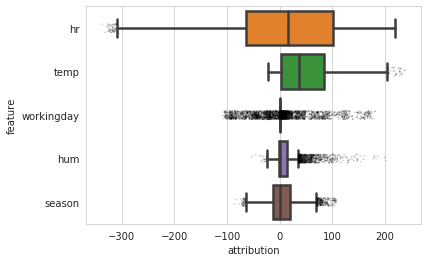

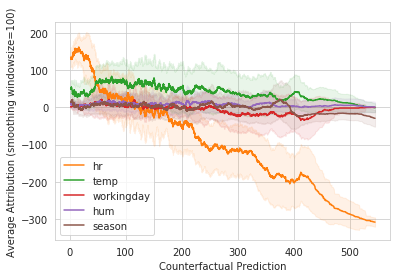

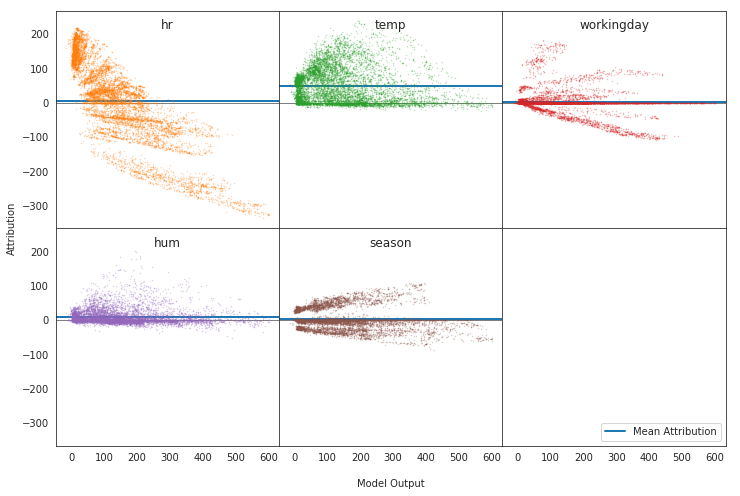

In [26]:
phi_0, phi = multi_shapley_values(model_fn, model_input, jm_sample_df)
phi_0_jm, phi_jm = phi_0, phi # save these


result_plots(phi_0, phi, fig_path=figures_dir, figname='bikeshare_joint_marginal')

In [27]:
pd.DataFrame([phi_marginal.mean().values / np.abs(phi_marginal.mean().values).sum(), 
              phi.mean().values / np.abs(phi.mean().values).sum()], 
             index=['Marginal (normalized)', 'Joint Marginal (normalized)'],
             columns=x_test.columns)

,hr,temp,workingday,hum,season
Marginal (normalized),0.042401,0.790108,0.022218,0.112842,0.032430
Joint Marginal (normalized),0.082694,0.724382,0.017104,0.129817,0.046004


# Clustering

In [28]:
phi_0, phi = phi_0_marginal, phi_marginal

In [29]:
# run clustering via sklearn
n_clusters = 5
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=0).fit(phi)
cluster_ids = kmeans.predict(phi) + 1

In [30]:
print('Cluster ranges:')
pd.Series(y_hat_test).groupby(cluster_ids).agg(['min', 'max']).style.format('{:.3f}')

Cluster ranges:


,min,max
1,131.045,483.406
2,-6.836,151.910
3,121.302,609.755
4,-9.598,291.808
5,10.350,311.004


Explained variance: 0.89


,hr,temp,workingday,hum,season
pca_1,-0.995642,0.090878,0.020283,-0.005142,-0.000004
pca_2,0.091781,0.989649,0.074615,0.013551,0.080132


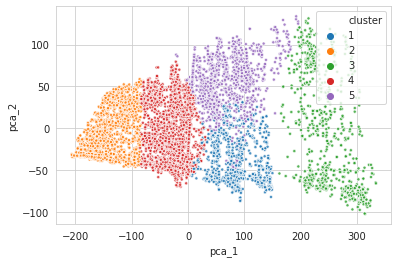

In [31]:
# project to 2-dimension via PCA to visualize 
pca = sklearn.decomposition.PCA(n_components=2).fit(phi)
two_dim_phi = pd.DataFrame(pca.transform(phi), columns=['pca_1', 'pca_2'])
print(f'Explained variance: {pca.explained_variance_ratio_.sum():.2f}')
display(pd.DataFrame(pca.components_, columns=phi.columns, index=['pca_1', 'pca_2']))

# plot results in PCA space
two_dim_phi['cluster'] = cluster_ids
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', palette=sns.color_palette()[:5], data=two_dim_phi, s=10, alpha=0.8)
plt.savefig(figures_dir / 'bikeshare_pca_cluster.png', bbox_inches='tight')
plt.show()

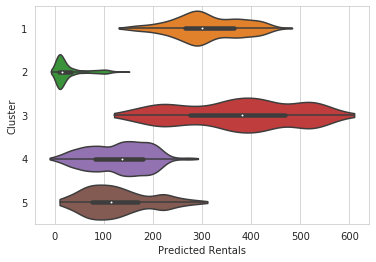

In [32]:
pred_by_cluster = pd.DataFrame({'Predicted Rentals': y_hat_test, 'Cluster': cluster_ids}).sort_values(by='Cluster')
pred_by_cluster['Cluster'] = pred_by_cluster['Cluster'].astype('category')
sns.violinplot(x='Predicted Rentals', y='Cluster', data=pred_by_cluster, scale='width', palette=sns.color_palette()[1:], cut=0)
# plt.title('Model prediction ranges for each cluster')
plt.savefig(figures_dir / 'bikeshare_cluster_violin.png', bbox_inches='tight')
plt.show()

In [33]:
def ci_95(series):
    return 1.96 * series.std() / np.sqrt(series.shape[0])

In [34]:
# display details of clusters
grouped = phi.groupby(two_dim_phi['cluster'])
groupwise_explanations = grouped.agg(['mean', 'std', ci_95]).round(2)
groupwise_explanations['total_delta'] = grouped.mean().sum(axis=1)
groupwise_explanations.insert(0, 'cluster_size', grouped.size().div(phi.shape[0]).apply(lambda x: f'{x:.1%}'))
groupwise_explanations.insert(0, 'avg_pred', phi_0.groupby(two_dim_phi['cluster']).mean().round())
print('model pred:', model_fn(model_input))
display(groupwise_explanations)

model pred: [209.87359579]


avg_pred cluster_size      hr                 temp               \
                                 mean    std ci_95    mean    std ci_95   
cluster                                                                   
1          309.0        12.9%  -86.08  33.61  1.96   13.93  24.98  1.46   
2           28.0        27.6%  140.29  31.20  1.25   32.11  30.09  1.20   
3          375.0        10.5% -247.20  40.65  2.64   58.49  65.41  4.24   
4          131.0        32.5%   31.32  26.90  0.99   37.99  36.42  1.34   
5          128.0        16.5%  -56.99  39.70  2.05  107.39  32.37  1.67   

        workingday                hum              season               \
              mean    std ci_95  mean    std ci_95   mean    std ci_95   
cluster                                                                  
1           -28.33  43.57  2.54  2.92  21.50  1.25  -1.28  21.43  1.25   
2             0.07  10.39  0.41  8.95  10.44  0.42   0.03  16.78  0.67   
3            16.37  33.37  2.16  8.94  26.06  1.69  -1.41  41.72  2.71   
4             3.47  19.18  0.71  4.38  15.63  0.57   2.06  24.54  0.90   
5            12.88  51.33  2.65  9.01  20.55  1.06   9.46  40.25  2.08   

        total_delta  
                     
cluster              
1        -98.850454  
2        181.447865  
3       -164.826819  
4         79.212620  
5         81.764013

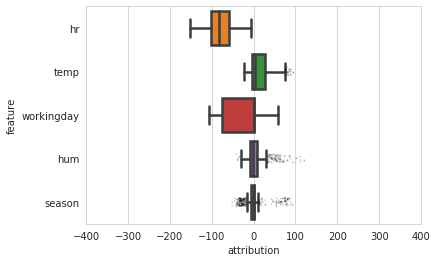

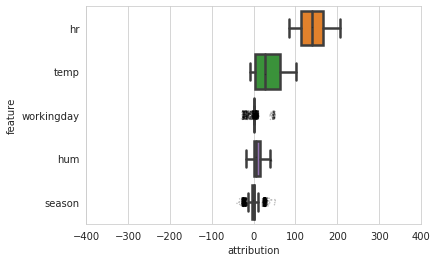

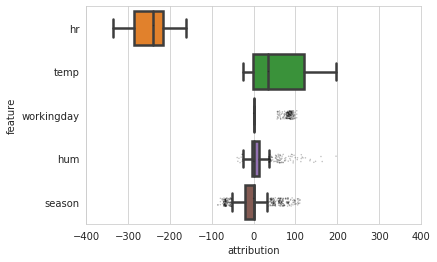

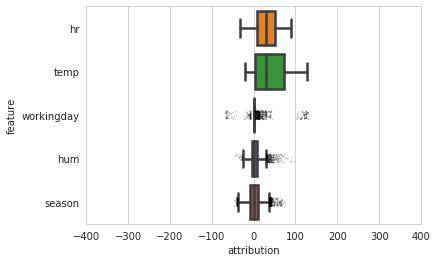

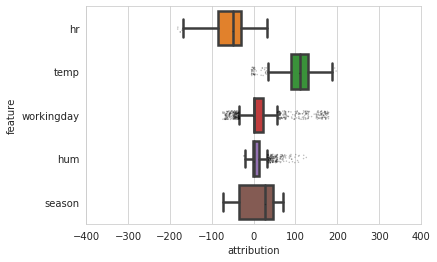

In [35]:
for i, group in grouped:
    plot_phi(group)
#     plt.title(f'Attributions vs cluster {i+1} ({group.shape[0]/phi.shape[0]:.1%} of data, avg_pred={groupwise_explanations.loc[i, "avg_pred"][0]:.2f})')
    plt.xlim(-400, 400)
    plt.savefig(figures_dir / f'bikeshare_cluster_{i}.png', bbox_inches='tight')
    plt.show()

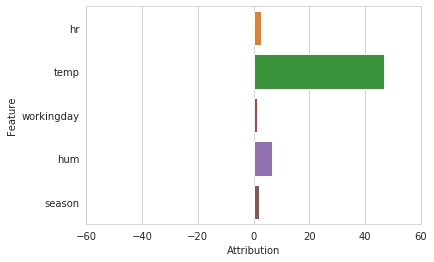

In [36]:
# mean of marginal attributions for comparison
sns.barplot(x=0, y='index', data=pd.Series(phi_marginal.mean(), index=phi_marginal.columns).reset_index(), palette=sns.color_palette()[1:])
plt.xlim(-60, 60)
plt.ylabel('Feature')
plt.xlabel('Attribution')
plt.title(None)
f.savefig(figures_dir / 'bikeshare_shap_values_barplot.png', bbox_inches='tight')
plt.show()

# Confidence intervals (overall)

In [37]:
marg_table = phi_marginal.agg(['mean', 'std', ci_95])
marg_table.insert(0, 'avg_pred', phi_0_marginal.agg(['mean', 'std', ci_95]))

jm_table = phi_jm.agg(['mean', 'std', ci_95])
jm_table.insert(0, 'avg_pred', phi_0_jm.agg(['mean', 'std', ci_95]))

unif_table = phi_unif.agg(['mean', 'std', ci_95])
unif_table.insert(0, 'avg_pred', phi_0_unif.agg(['mean', 'std', ci_95]))

for table in (marg_table, jm_table, unif_table):
    display(table.round(1))

,avg_pred,hr,temp,workingday,hum,season
mean,150.6,2.5,46.8,1.3,6.7,1.9
std,130.7,121.3,47.2,33.3,17.8,28.2
ci_95,2.7,2.5,1.0,0.7,0.4,0.6


,avg_pred,hr,temp,workingday,hum,season
mean,140.8,5.7,50.0,1.2,9.0,3.2
std,118.4,119.9,51.7,32.7,21.0,30.7
ci_95,2.5,2.5,1.1,0.7,0.4,0.6


,avg_pred,hr,temp,workingday,hum,season
mean,128.5,3.4,60.4,3.0,12.1,2.5
std,112.8,112.4,54.6,39.6,27.1,30.0
ci_95,2.4,2.4,1.1,0.8,0.6,0.6


In [38]:
phi_marginal.shape[0]

8734

In [39]:
phi_marginal.mean()

hr             2.514198
temp          46.849887
workingday     1.317458
hum            6.691037
season         1.922960
dtype: float64

In [40]:
hundred_mean = phi_marginal.sample(100, random_state=0).mean()
hundred_mean

hr           -10.443292
temp          41.180851
workingday     4.917767
hum            7.603066
season         2.100621
dtype: float64

In [41]:
hundred_ci = phi_marginal.sample(100, random_state=0).apply(ci_95)
hundred_ci

hr            25.449412
temp           8.750036
workingday     5.935048
hum            4.150170
season         5.067558
dtype: float64

In [42]:
# for 100 sample
ci_table = pd.DataFrame([hundred_mean - hundred_ci, hundred_mean + hundred_ci])
ci_table.index = ['lower_bound', 'upper_bound']
ci_table

,hr,temp,workingday,hum,season
lower_bound,-35.892704,32.430815,-1.017281,3.452896,-2.966938
upper_bound,15.006120,49.930887,10.852815,11.753236,7.168179


In [43]:
# for full sample
ci_table = pd.DataFrame([marg_table.loc['mean'] - marg_table.loc['ci_95'], marg_table.loc['mean'] + marg_table.loc['ci_95']])
ci_table.index = ['lower_bound', 'upper_bound']
ci_table

,avg_pred,hr,temp,workingday,hum,season
lower_bound,147.835968,-0.029433,45.860445,0.619662,6.318080,1.331732
upper_bound,153.320145,5.057829,47.839328,2.015253,7.063993,2.514188
